**Let's try and understand what exactly is going on behind the scenes with this data ...**

In [176]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import re
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

In [165]:
# Get data stored in h5 file for performance
with pd.HDFStore("../input/train.h5", "r") as train:
    df = train.get("train")

In [166]:
#Get a peek at the top of the data
df.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,...,0.151881,NaN,NaN,NaN,-0.175710,NaN,NaN,-2.0,NaN,-0.020940
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,...,1.035936,NaN,NaN,NaN,-0.211506,NaN,NaN,-2.0,NaN,-0.015959
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0.630232,NaN,NaN,NaN,-0.001957,NaN,NaN,0.0,NaN,-0.007338


According to this walkthrough, **id** probably refers to a particular asset, i.e. stock.  How many of those are there?

In [167]:
print('Number of unique stocks: ', len(df.id.unique()))  
print('Number of timestamps (in training set):', len(df.timestamp.unique()))

Number of unique stocks:  1424
Number of timestamps (in training set): 1813


OK, so how many stocks are there at a given time?

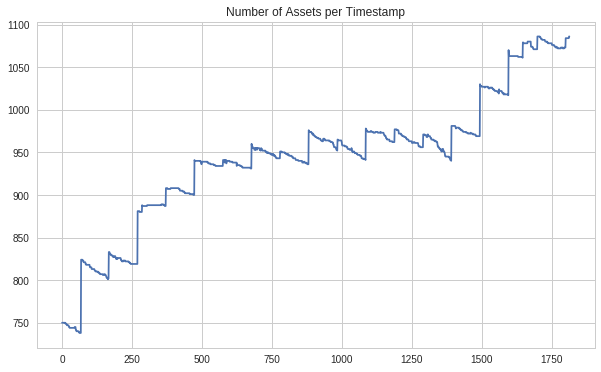

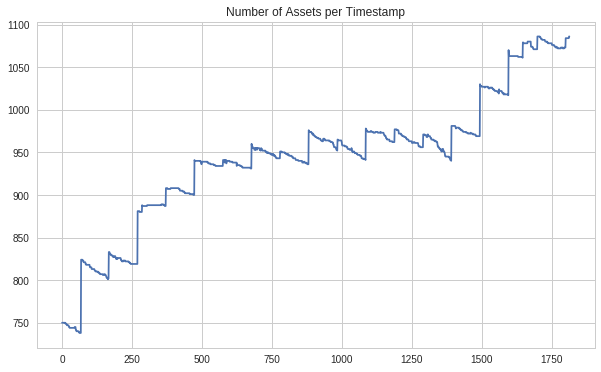

In [175]:
stocks_per_time = df.groupby('timestamp').count()
plt.plot(stocks_per_time.index, stocks_per_time.id)
plt.title("Number of Assets per Timestamp") #Ignore duplicate plots

So, we can see that the number of assets in this portfolio (so to speak) isn't constant over time, and nor does every stock exist at any one point (notice how the number of assets never reaches 1424, the number of distinct assets we found earlier). The number of stocks does seem to increase over time though. 


How much data (number of timestamps) do we have for a given stock? Let's get a histogram to take a look. 

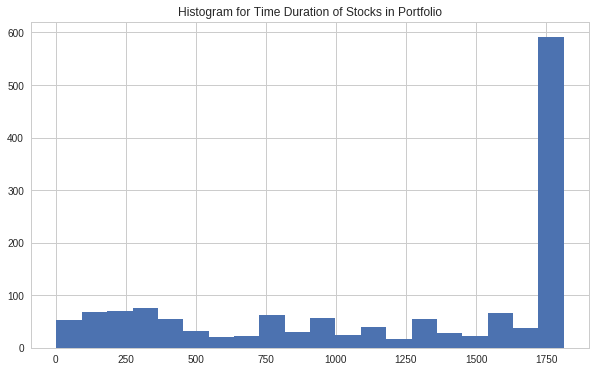

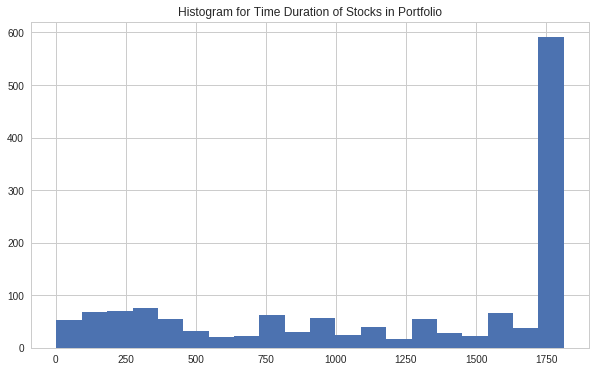

In [169]:
stock_duration = df.groupby('id').count()
stock_duration.timestamp.hist(bins = 20)
plt.title('Histogram for Time Duration of Stocks in Portfolio')

Although about 600 stocks (around 40%) seem to span all or nearly all of the time interval, a majority don't. Why is that the case? Presumably, short-lived stocks were bad performing while the longer-tenured stocks had high returns. Can we verify this? 

Let's take a look at some of the stocks that have values for all timestamps in this dataset:

In [170]:
stock_duration.timestamp.sort(inplace=False, ascending = False).head(10)

id
1066    1813
704     1813
697     1813
699     1813
1548    1813
703     1813
1545    1813
1543    1813
1539    1813
691     1813
Name: timestamp, dtype: int64

Let's graph the first five of these looking at their y-value and their _cumulative_ y-value over all the time periods. The latter gives us a better sense of the asset performance since it effectively tells us the returns.

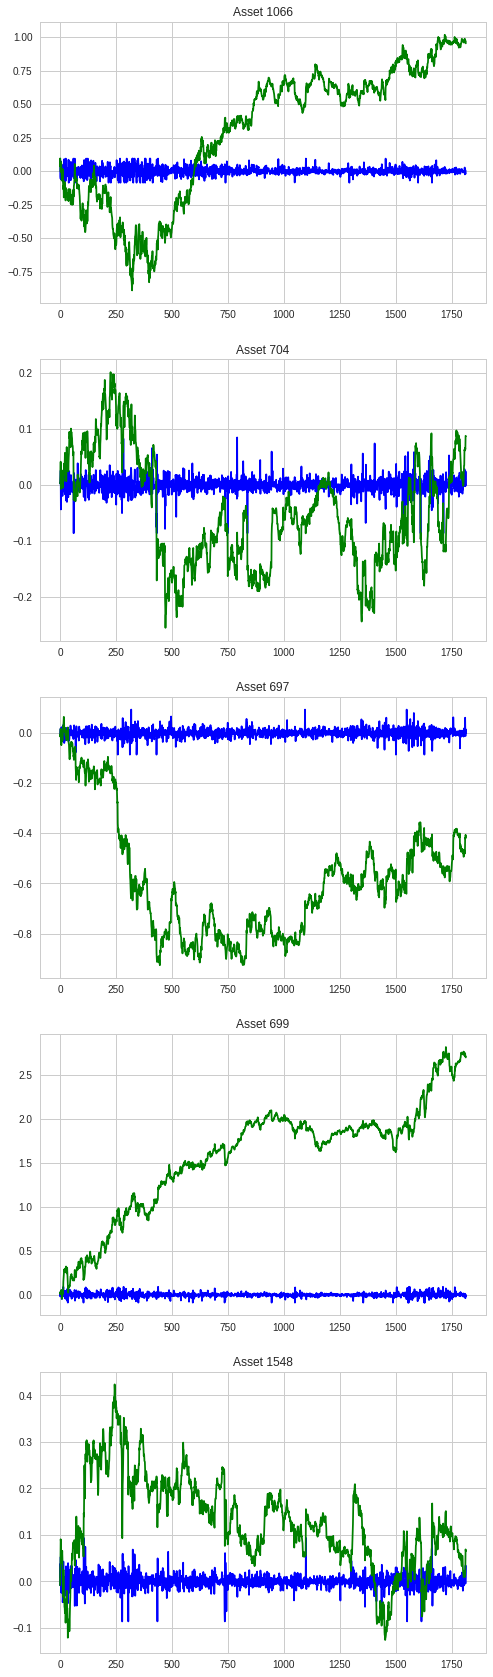

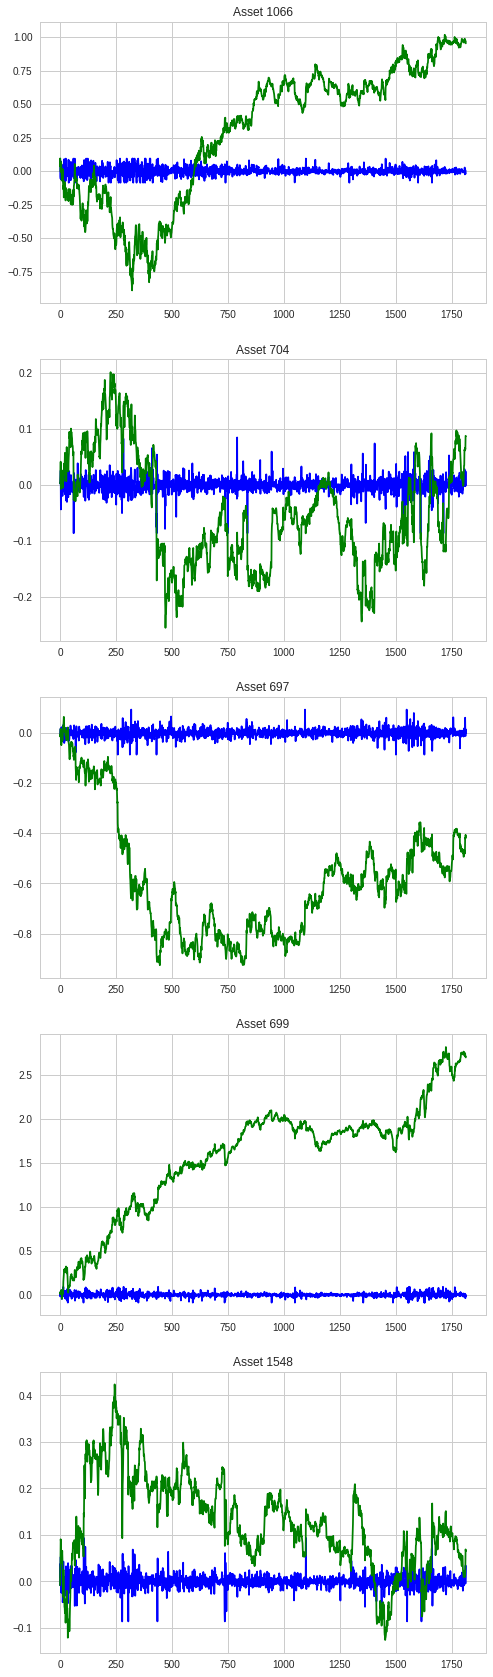

In [171]:
ids = [1066, 704, 697, 699, 1548]

def asset_performance(ids):
    '''
    Plots cumulative and incremental of assets over the total time 
    included in portfolio
    '''
    fig = plt.figure(figsize=(8, 30)) 
    for plot_count, index in enumerate(ids):
        id_df = df[df.id == index]
        plot_count +=1
        plt.subplot(5,1,plot_count)
        plt.plot(id_df.timestamp, id_df.y, color = 'b')
        plt.plot(id_df.timestamp, id_df.y.cumsum(), color = 'g')
        plt.title('Asset ' + str(index))

asset_performance(ids) #ignore duplicate plots if they appear


So, interestingly enough, only 1066 and 669 actually made substantial gains over that time period (the latter especially :)). At the very least, none of them had a monotonically decreasing shape. 

What about the shorter lived assets? 

In [172]:
stock_duration.timestamp.sort(inplace=False, ascending = True).head(5)

id
1229     2
1893     2
435      2
1056     8
980     12
Name: timestamp, dtype: int64

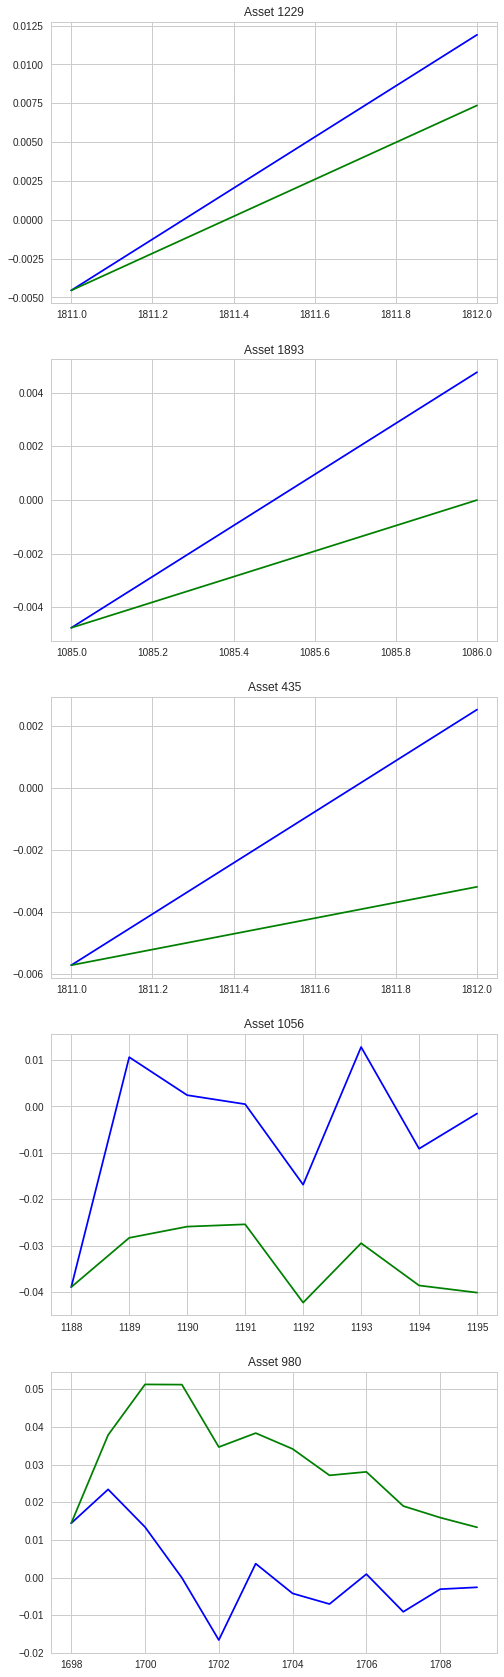

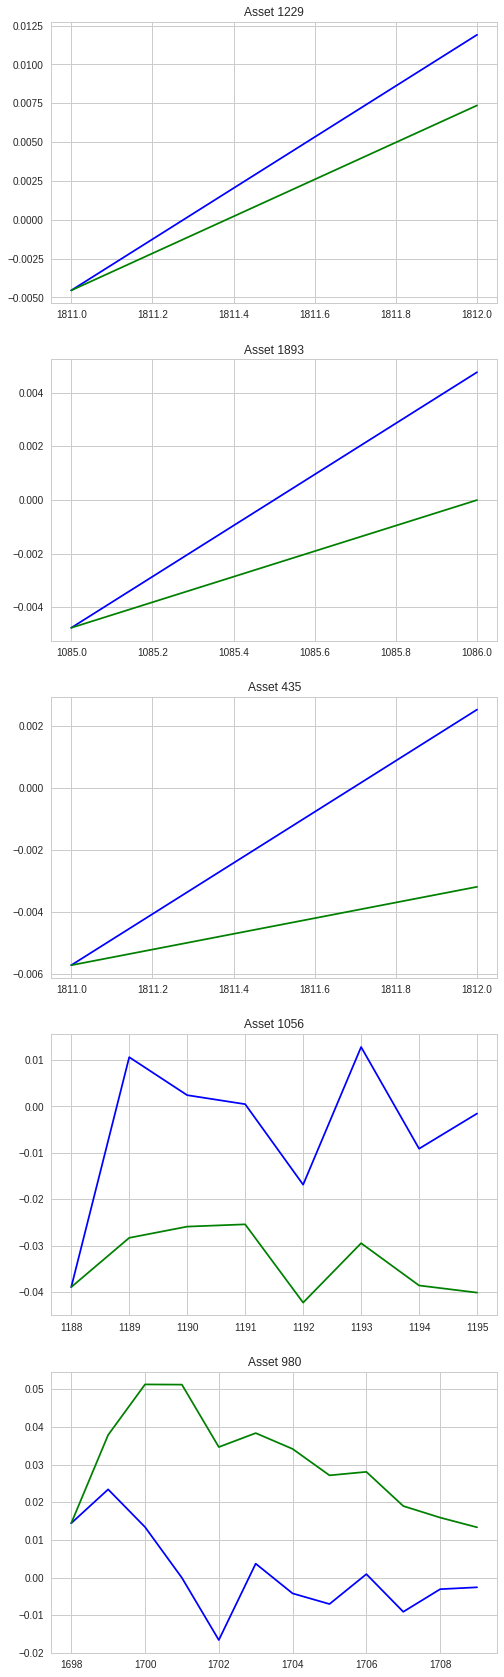

In [173]:
ids_short = [1229, 1893, 435, 1056, 980]
asset_performance(ids_short) #ignore duplicate plots if they appear 

So, that doesn't tell us much either -- only two of those five stocks (1056, 435) actually lost money :/ 


So, I don't actually know all that much about portfolio management, or why stocks seem to randomly come and go within this dataset regardless of performance. However, a friend of mine and fellow Galvanize peep (John Zhu) pointed out that asset managers like to keep their portfolio _diversified_ such that the assets within a portfolio are _uncorrelated_. 

Presumably, this important since if all the stocks are correlated and they turn downwards -- well, you just lost a lot of money! 

Let's take a look at the correlation of stocks over the first five timestamps: 

In [152]:
# helper function for later on ... Sorry, I like writing complicated code production-style
def lists_to_pandas(y_values_list, time_values_list, assets_list):
    '''
    INPUT: List of lists of y-values for assets over this time period, the timestamps for this interval,
    a list of asset labels corresponding to `y_values_list`. 
    OUTPUT: Pandas dataframe with timestamps as index/rows and each asset a column
    '''
    y_val_df = pd.DataFrame(y_values_list).transpose()
    y_val_df.columns = assets_list
    y_val_df.set_index(time_values_list, inplace = True)
    return y_val_df

def get_asset_performance(df, start=0):
    '''
    INPUT: parameter for what range timestamps to analyze
    OUTPUT: Dataframe from `list_to_pandas` 
    '''
    df_temp = df[df.timestamp.isin(range(start, start+5))]
    y_values = dict()
    for asset in df_temp.id.unique():
        asset_df = df_temp[df.id == asset]
        if len(asset_df.timestamp) == 5: 
            # We only include y-values that have been in the portfolio for (all) 5 timestamps
            y_values[asset] = asset_df.y.tolist()
    return lists_to_pandas(list(y_values.values()), df_temp.timestamp.unique(), y_values.keys()) 


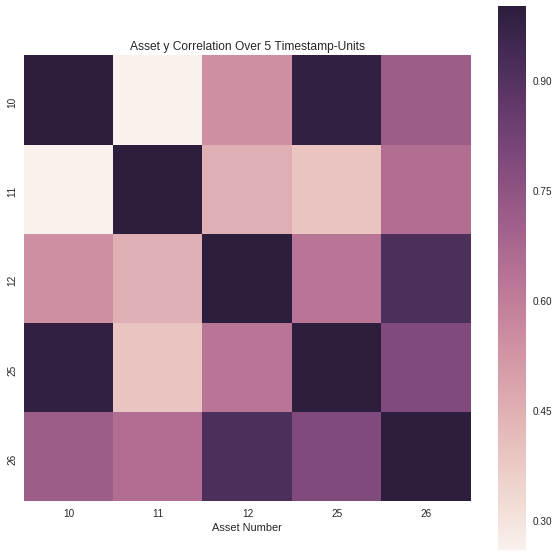

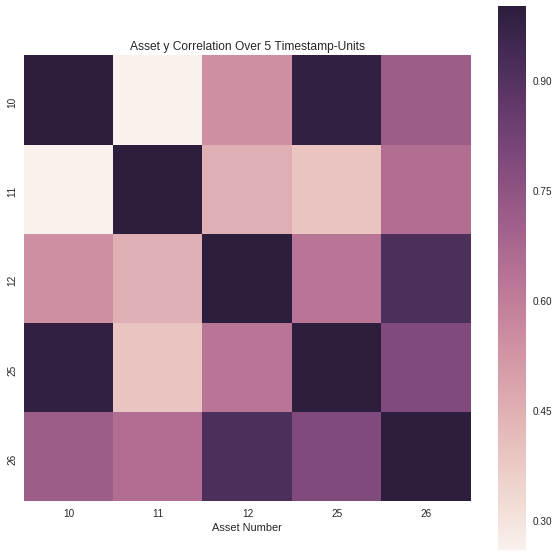

In [140]:
y_df = get_asset_performance(df, 0)
corr_mat = y_df[[10,11,12,25,26]].corr()
fig = plt.figure(figsize=(10, 10)) 
sns.heatmap(corr_mat, square=True)
plt.xlabel('Asset Number')
plt.title('Asset y Correlation Over 5 Timestamp-Units') 
#Ignore duplicate plot 


So, that's interesting -- assets 10 and 11 are fairly uncorrelated, but 25 and 26 are pretty closely related. 

I would visualize all the asset correlations ... but there are 750 different assets in this timeframe! Hard to see. Dimensionality reduction (PCA, etc.) would be pretty smart here. 

(Although I don't do it here, although an interesting point might be looking at the plots of the most correlated/least correlated stocks.) 

A good question is whether my range, 5, is too small or too large for measuring correlations. We can (sort-of) get around this by looking at a _sliding window_ of size five across all the data. If this is a well-diversified portfolio, the overall correlation of the portfolio should hover around zero. Does it? 

In [153]:
#This will take a while to compute ... 
corr_list = []
for start in range(max(df.timestamp.unique())+1-5): #So that last range will end with last timestamp
    print(start)
    temp_df = get_asset_performance(df, start)
    corr_list.append(temp_df.corr().mean().mean())

0
0


/opt/conda/bin/ipython:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/bin/ipython:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
143
144
144
145
145
146
146
147
147
148
148
149
149
150
150
151
151
152
152


KeyboardInterrupt: 

KeyboardInterrupt: 

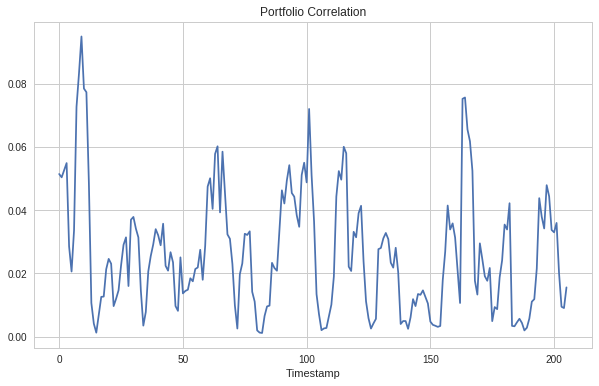

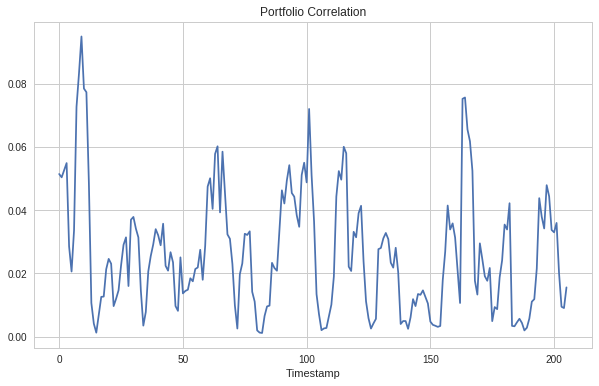

In [162]:
plt.plot(corr_list)
plt.xlabel('Timestamp')
plt.title('Portfolio Correlationb')

**FASCINATING!** The correlation of stocks is cyclical -- once it reaches 0.06 or so, it crashes down to zero again. 

I don't know enough to say if these are good values for a diversified portfolio. A correlation below 0.1 _seems_ to be good, though. 

One has to wonder if stocks are dropped based on increasing correlations. What else could we look at?